# Question 2
## Multi Layer Perceptron for Regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")
# %load_ext autoreload
# %autoreload 2

### Preprocessing

In [2]:
from models import CustomDataset, Model, plot_loss_acc, plot_loss_acc_comparision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

df = pd.read_csv('Reg-Data.csv', header=None)

target_index = -2
X = df.iloc[:, :target_index].values
X = X.astype(np.float32)

y = df.iloc[:, -2:].values



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# StandardScaler the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

### 1) LinearRegression

mse test for linear regression 1151.5694021967267
mse val for Ridge regression with best alpha=212 1184.997640747371
mse test for Ridge regression with best alpha=212 1133.8888583680614


212

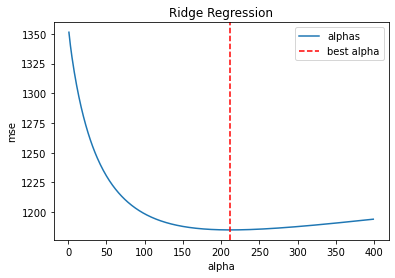

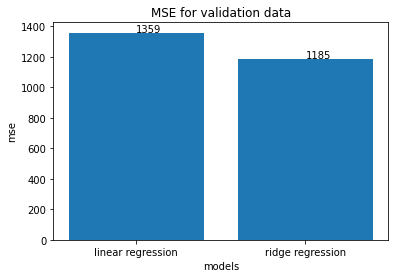

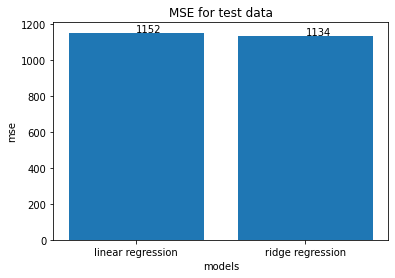

In [3]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_hat_val = model.predict(X_val)
y_hat_test = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error

linear_regression_mse_val = mean_squared_error(y_val, y_hat_val)
linear_regression_mse_test = mean_squared_error(y_test, y_hat_test)

print('mse test for linear regression', linear_regression_mse_test)

from sklearn.linear_model import Ridge

alphas = [i for i in range(1, 400)]
mses = [] 
for alpha in alphas: 
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)

    y_hat = model.predict(X_val)
    mse = mean_squared_error(y_val, y_hat)

    mses.append(mse)

best_alpha = alphas[np.argmin(mses)]

model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)

y_hat_val = model.predict(X_val)
y_hat_test = model.predict(X_test)

ridge_regression_mse_val = mean_squared_error(y_val, y_hat_val)
ridge_regression_mse_test = mean_squared_error(y_test, y_hat_test)

print(f'mse val for Ridge regression with best alpha={best_alpha}', ridge_regression_mse_val)
print(f'mse test for Ridge regression with best alpha={best_alpha}', ridge_regression_mse_test)

plt.plot(alphas, mses, label='alphas')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Ridge Regression')
plt.axvline(x=best_alpha, color='r', linestyle='--', label='best alpha')
plt.legend()

plt.figure()
two_model = ['linear regression', 'ridge regression']
two_mses_vals = [linear_regression_mse_val, ridge_regression_mse_val]
plt.bar(two_model, two_mses_vals,label='mse')
plt.xlabel('models')
plt.ylabel('mse')
plt.title('MSE for validation data')
for i, v in zip(two_model, two_mses_vals):
    plt.text(i, v + 5, round(v))

two_mse_tests = [linear_regression_mse_test, ridge_regression_mse_test]
plt.figure()
plt.bar(two_model, two_mse_tests,label='mse')
plt.xlabel('models')
plt.ylabel('mse')
plt.title('MSE for test data')
for i, v in zip(two_model, two_mse_tests):
    plt.text(i, v + 5, round(v))

best_alpha

### 2) Simple NN

In [4]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

batch_size = 32
epochs = 10
learning_rate = 0.01

model = Model(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, hidden_layers_num=0)

### 2) different loss, optimizer and epoch

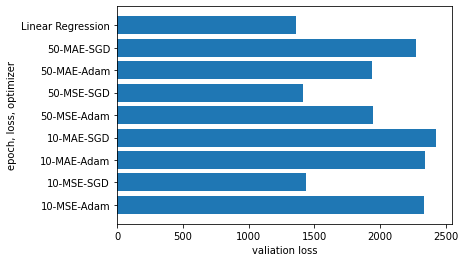

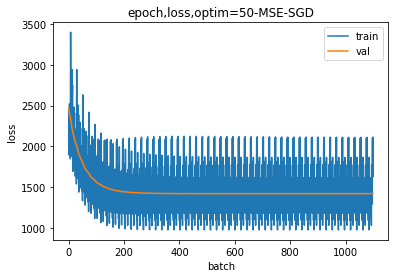

In [5]:
import itertools
batch_size = 32
epochs = [10, 50]
learning_rate = 0.01
loss_trains = []
loss_vals = []
test_losses = []
losses = ['MSE', 'MAE']
optimizers = ['Adam', 'SGD']

for i in itertools.product(epochs, losses, optimizers):
    epoch = i[0]
    loss = i[1]
    optimizer = i[2]

    model = Model(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer) 
    results = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.01)
    loss_train, loss_val, test_loss = results
    loss_trains.append(loss_train)
    loss_vals.append(loss_val)
    test_losses.append(test_loss)

hyper_parameters = itertools.product(epochs, losses, optimizers)

hyper_parameters = [str(i[0]) + '-' + str(i[1]) + '-' + str(i[2]) for i in hyper_parameters]  
  
plot_loss_acc_comparision(hyper_parameters + ['Linear Regression'], 'epoch, loss, optimizer', loss_vals + [[linear_regression_mse_val]])


best_loss_val_arg = np.argmin([loss[-1] for loss in loss_vals])

title = f'epoch,loss,optim={hyper_parameters[best_loss_val_arg]}'
plot_loss_acc(loss_trains[best_loss_val_arg], loss_vals[best_loss_val_arg], title)

best_loss_val = loss_vals[best_loss_val_arg][-1]

### 3) adding non-linear activation function

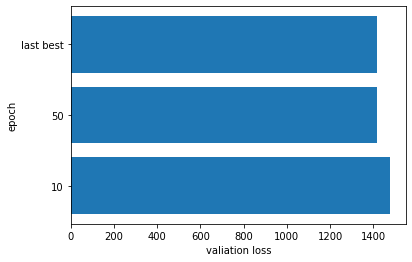

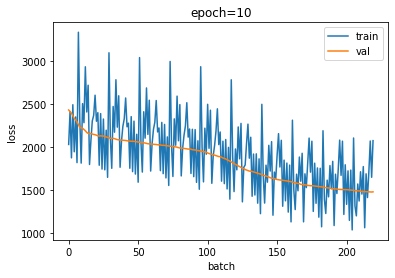

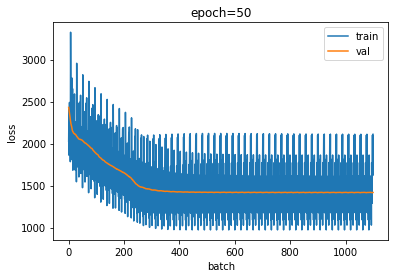

In [6]:
batch_size = 32
epochs = [10, 50]
learning_rate = 0.01
loss_trains = []
loss_vals = []
test_losses = []
loss = 'MSE'
optimizer = 'SGD'


for epoch in epochs:
    model = Model(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, activation='relu') 
    results = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.01)
    loss_train, loss_val, test_loss = results
    loss_trains.append(loss_train)
    loss_vals.append(loss_val)
    test_losses.append(test_loss)


hyper_parameters = [str(i) for i in epochs]   
plot_loss_acc_comparision(hyper_parameters + ['last best'], 'epoch', loss_vals + [[best_loss_val]])

for i, paramters in enumerate(epochs):
    title = f'epoch={paramters}'
    plot_loss_acc(loss_trains[i], loss_vals[i], title)


best_loss_val_arg = np.argmin([loss[-1] for loss in loss_vals])
best_loss_val = loss_vals[best_loss_val_arg][-1]

### 4) different batch_size

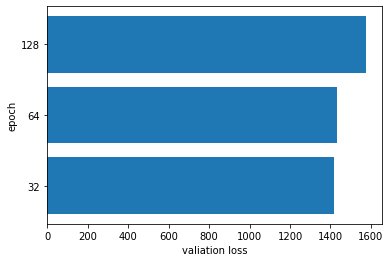

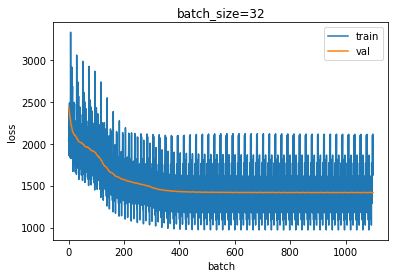

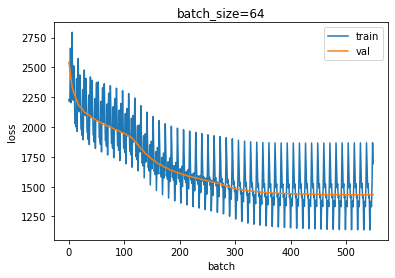

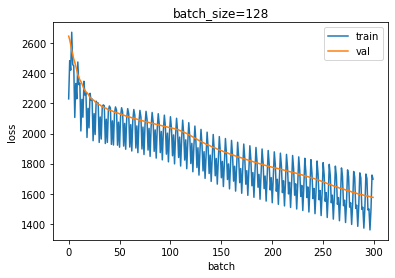

In [7]:
batch_size = 32
epochs = 30
learning_rate = 0.01
loss_trains = []
loss_vals = []
test_losses = []
loss = 'MSE'
optimizer = 'SGD'
batch_sizes = [32, 64, 128]

for batch_size in batch_sizes:

    model = Model(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, activation='relu') 
    results = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.01)
    loss_train, loss_val, test_loss = results
    loss_trains.append(loss_train)
    loss_vals.append(loss_val)
    test_losses.append(test_loss)


hyper_parameters = [str(i) for i in batch_sizes]    
plot_loss_acc_comparision(hyper_parameters, 'epoch', loss_vals)

for i, paramters in enumerate(batch_sizes):
    title = f'batch_size={paramters}'
    plot_loss_acc(loss_trains[i], loss_vals[i], title)

### 5) adding hidden layer

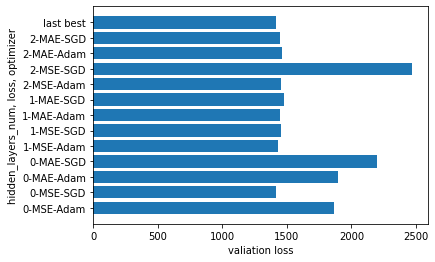

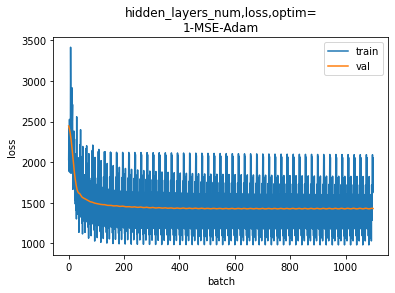

In [8]:
batch_size = 32
epoch = 50
learning_rate = 0.01
loss_trains = []
loss_vals = []
test_losses = []
hidden_layers_nums = [0, 1, 2]
losses = ['MSE', 'MAE']
optimizers = ['Adam', 'SGD']

for i in itertools.product(hidden_layers_nums, losses, optimizers):
    hidden_layers_num = i[0]
    loss = i[1]
    optimizer = i[2]

    model = Model(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, hidden_layers_num=hidden_layers_num, activation='relu') 
    results = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.01)
    loss_train, loss_val, test_loss = results
    loss_trains.append(loss_train)
    loss_vals.append(loss_val)
    test_losses.append(test_loss)

hyper_parameters = itertools.product(hidden_layers_nums, losses, optimizers)

hyper_parameters = [str(i[0]) + '-' + str(i[1]) + '-' + str(i[2]) for i in hyper_parameters]  
  
plot_loss_acc_comparision(hyper_parameters + ['last best'], 'hidden_layers_num, loss, optimizer', loss_vals + [[best_loss_val]])

best_loss_val_arg = np.argmin([loss[-1] for loss in loss_vals])

title = f'hidden_layers_num,loss,optim=\n{hyper_parameters[4]}'
plot_loss_acc(loss_trains[4], loss_vals[4], title)

best_loss_val = loss_vals[best_loss_val_arg][-1]

### 6) adding dropout

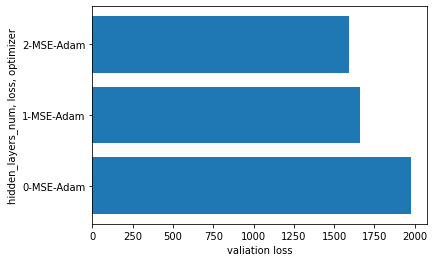

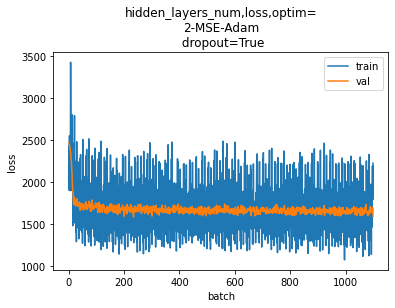

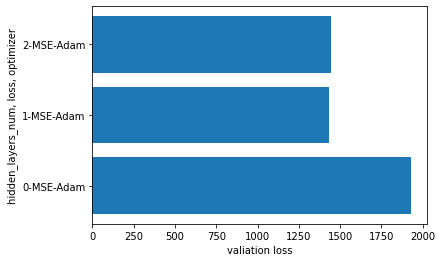

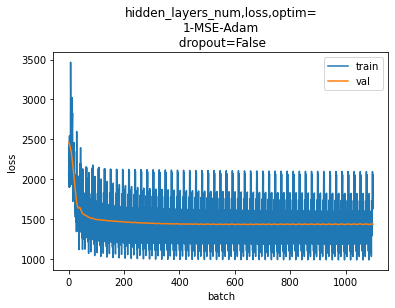

In [10]:
batch_size = 32
epoch = 50
learning_rate = 0.01
loss_trains = []
loss_vals = []
test_losses = []
hidden_layers_nums = [0, 1, 2]
losses = ['MSE']
optimizers = ['Adam']

for i in itertools.product(hidden_layers_nums, losses, optimizers):
    hidden_layers_num = i[0]
    loss = i[1]
    optimizer = i[2]

    model = Model(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, hidden_layers_num=hidden_layers_num, activation='relu',
                 dropout=True) 
    results = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.01)
    loss_train, loss_val, test_loss = results
    loss_trains.append(loss_train)
    loss_vals.append(loss_val)
    test_losses.append(test_loss)

hyper_parameters = itertools.product(hidden_layers_nums, losses, optimizers)

hyper_parameters = [str(i[0]) + '-' + str(i[1]) + '-' + str(i[2]) for i in hyper_parameters]  
  
plot_loss_acc_comparision(hyper_parameters, 'hidden_layers_num, loss, optimizer', loss_vals)

best_loss_val_arg = np.argmin([loss[-1] for loss in loss_vals])

title = f'hidden_layers_num,loss,optim=\n{hyper_parameters[best_loss_val_arg]}\n dropout=True'
plot_loss_acc(loss_trains[best_loss_val_arg], loss_vals[best_loss_val_arg], title)

batch_size = 32
epoch = 50
learning_rate = 0.01
loss_trains = []
loss_vals = []
test_losses = []
hidden_layers_nums = [0, 1, 2]
losses = ['MSE']
optimizers = ['Adam']

for i in itertools.product(hidden_layers_nums, losses, optimizers):
    hidden_layers_num = i[0]
    loss = i[1]
    optimizer = i[2]

    model = Model(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, hidden_layers_num=hidden_layers_num, activation='relu',
                 dropout=False) 
    results = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.01)
    loss_train, loss_val, test_loss = results
    loss_trains.append(loss_train)
    loss_vals.append(loss_val)
    test_losses.append(test_loss)

hyper_parameters = itertools.product(hidden_layers_nums, losses, optimizers)

hyper_parameters = [str(i[0]) + '-' + str(i[1]) + '-' + str(i[2]) for i in hyper_parameters]  
  
plot_loss_acc_comparision(hyper_parameters, 'hidden_layers_num, loss, optimizer', loss_vals)

best_loss_val_arg = np.argmin([loss[-1] for loss in loss_vals])

title = f'hidden_layers_num,loss,optim=\n{hyper_parameters[best_loss_val_arg]}\n dropout=False'
plot_loss_acc(loss_trains[best_loss_val_arg], loss_vals[best_loss_val_arg], title)


best_loss_val = loss_vals[best_loss_val_arg][-1]

### 7)adding batch normalization

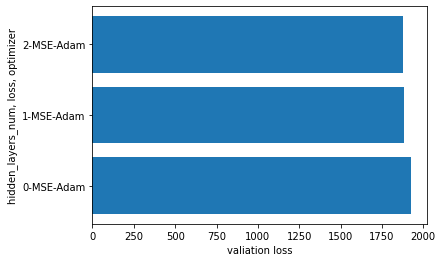

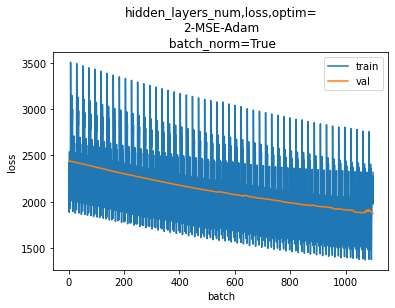

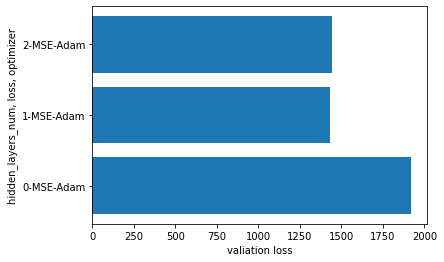

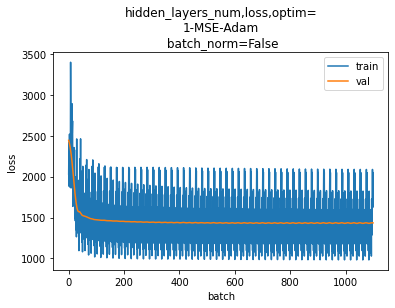

In [14]:
batch_size = 32
epoch = 50
learning_rate = 0.01
loss_trains = []
loss_vals = []
test_losses = []
hidden_layers_nums = [0, 1, 2]
losses = ['MSE']
optimizers = ['Adam']

for i in itertools.product(hidden_layers_nums, losses, optimizers):
    hidden_layers_num = i[0]
    loss = i[1]
    optimizer = i[2]

    model = Model(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, hidden_layers_num=hidden_layers_num, activation='relu',
                 dropout=False, batch_norm=True) 
    results = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.01)
    loss_train, loss_val, test_loss = results
    loss_trains.append(loss_train)
    loss_vals.append(loss_val)
    test_losses.append(test_loss)

hyper_parameters = itertools.product(hidden_layers_nums, losses, optimizers)

hyper_parameters = [str(i[0]) + '-' + str(i[1]) + '-' + str(i[2]) for i in hyper_parameters]  
  
plot_loss_acc_comparision(hyper_parameters, 'hidden_layers_num, loss, optimizer', loss_vals)

best_loss_val_arg = np.argmin([loss[-1] for loss in loss_vals])

title = f'hidden_layers_num,loss,optim=\n{hyper_parameters[best_loss_val_arg]}\n batch_norm=True'
plot_loss_acc(loss_trains[best_loss_val_arg], loss_vals[best_loss_val_arg], title)

batch_size = 32
epoch = 50
learning_rate = 0.01
loss_trains = []
loss_vals = []
test_losses = []
hidden_layers_nums = [0, 1, 2]
losses = ['MSE']
optimizers = ['Adam']

for i in itertools.product(hidden_layers_nums, losses, optimizers):
    hidden_layers_num = i[0]
    loss = i[1]
    optimizer = i[2]

    model = Model(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, hidden_layers_num=hidden_layers_num, activation='relu',
                 dropout=False, batch_norm=False) 
    results = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.01)
    loss_train, loss_val, test_loss = results
    loss_trains.append(loss_train)
    loss_vals.append(loss_val)
    test_losses.append(test_loss)

hyper_parameters = itertools.product(hidden_layers_nums, losses, optimizers)

hyper_parameters = [str(i[0]) + '-' + str(i[1]) + '-' + str(i[2]) for i in hyper_parameters]  
  
plot_loss_acc_comparision(hyper_parameters, 'hidden_layers_num, loss, optimizer', loss_vals)

best_loss_val_arg = np.argmin([loss[-1] for loss in loss_vals])

title = f'hidden_layers_num,loss,optim=\n{hyper_parameters[best_loss_val_arg]}\n batch_norm=False'
plot_loss_acc(loss_trains[best_loss_val_arg], loss_vals[best_loss_val_arg], title)


best_loss_val = loss_vals[best_loss_val_arg][-1]

### 8) final

test loss=1616.6906476702009


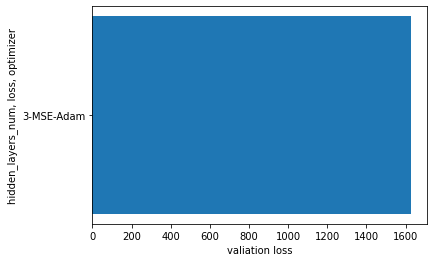

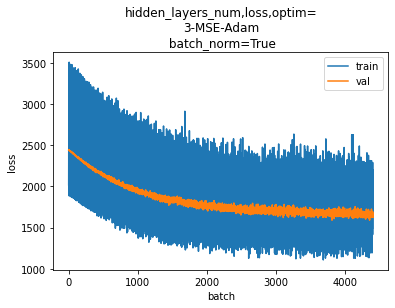

In [16]:
batch_size = 32
epoch = 200
learning_rate = 0.01
loss_trains = []
loss_vals = []
test_losses = []
hidden_layers_nums = [3]
losses = ['MSE']
optimizers = ['Adam']

for i in itertools.product(hidden_layers_nums, losses, optimizers):
    hidden_layers_num = i[0]
    loss = i[1]
    optimizer = i[2]

    model = Model(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, hidden_layers_num=hidden_layers_num, activation='relu',
                 dropout=True, batch_norm=True) 
    results = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.01)
    loss_train, loss_val, test_loss = results
    loss_trains.append(loss_train)
    loss_vals.append(loss_val)
    test_losses.append(test_loss)

hyper_parameters = itertools.product(hidden_layers_nums, losses, optimizers)

hyper_parameters = [str(i[0]) + '-' + str(i[1]) + '-' + str(i[2]) for i in hyper_parameters]  
  
plot_loss_acc_comparision(hyper_parameters, 'hidden_layers_num, loss, optimizer', loss_vals)

best_loss_val_arg = np.argmin([loss[-1] for loss in loss_vals])

title = f'hidden_layers_num,loss,optim=\n{hyper_parameters[best_loss_val_arg]}\n batch_norm=True'
plot_loss_acc(loss_trains[best_loss_val_arg], loss_vals[best_loss_val_arg], title)
print(f'test loss={test_losses[best_loss_val_arg]}')